In [216]:
# Downloading PDFs
import requests
from bs4 import BeautifulSoup
import wget

# Data handling
import pandas as pd
import numpy as np
import datetime
import re

# Statistics
import statsmodels.tsa.x13 as sx13

# I/O
import os

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# set directory for files to be stored
DIR = "Data"
os.chdir(DIR)

### Downloading PDFs

In [21]:
# url template for table listing page
main_page = "https://www2.census.gov/programs-surveys/qtax/tables/{}/q4t1.pdf"

In [23]:
years = map(str,range(1962,1994))
for year in years:
    try:
        wget.download(main_page.format(year), "{}.pdf".format(year))
    except:
        print("{} table failed to download".format(year))

1962 table failed to download
1977 table failed to download
1979 table failed to download
1981 table failed to download
1983 table failed to download
1992 table failed to download


Notes: 
Went back and manually downloaded the tables that raised errors
Only quarters 1 and 2 available for 1992

### Reading and organizing data

In [217]:
''' Read in all tax data
Columns:
Period - indicates yaer and quarter in format (YYYY-Q[1-4])
Category - indicates type of tax. Types included are:
    - Property 
    - General Sales and Gross Receipts 
    - Alcoholic Beverages Sales 
    - Amusements Sales 
    - Insurance Premiums Sales 
    - Motor Fuels Sales 
    - Pari-Mutuels Sales 
    - Public Utilities Sales 
    - Tobacco Products Sales 
    - Other Selective Sales and Gross Receipts 
    - Alcoholic Beverages License
    - Amusements License
    - Corporations in General License
    - Hunting and Fishing License
    - Motor Vehicles License
    - Motor Vehicles Operators License
    - Public Utilities License
    - Occupation and Business License
    - Other License 
    - Individual Income 
    - Corporation Net Income 
    - Death and Gift 
    - Documentary and Stock Transfer 
    - Severance 
    - Other Not Elsewhere Classified
    - Total 
    See dataset documentation for detail on category definitions.
State - indicates state with postal abbreviation. US denotes the total of all states except the District of Columbia.
Value - indicates revenue in millions of dollars. Negative numbers indicate that refunds exceeded revenues.
'''

# Note: I did some initial data cleanup (e.g. renaming columns, deleting unneccessary columns, INDEX/MATCH-ing numerical keys
# with their corresponding English language values for ease of reference) in Excel. When I have some time I'll automate the
# data cleaning in pandas so new quarters can be added quickly.

file_path = "QTAX-edit.csv"
qtax_full = pd.read_csv(file_path, header = 0, index_col = "Period",
                       dtype = {'Category':'S','State':'S','Value':'i8'},parse_dates = True, infer_datetime_format = True)
qtax_full.dropna(inplace = True)

In [4]:
# Checking that data is structured correctly
qtax_full.head()
qtax_full.tail()

,Category,State,Value
Period,,,
2020-01-01,Total,VT,631
2020-01-01,Total,WA,8254
2020-01-01,Total,WI,4140
2020-01-01,Total,WV,1325
2020-01-01,Total,WY,446


In [227]:
totals = qtax_full[qtax_full.Category == "Total"]
# Pull totals for 15 most populous states
california_total = totals[totals.State == "CA"]["Value"]
texas_total = totals[totals.State == "TX"]["Value"]
florida_total = totals[totals.State == "FL"]["Value"]
newyork_total = totals[totals.State == "NY"]["Value"]
pennsylvania_total = totals[totals.State == "PA"]["Value"]
illinois_total = totals[totals.State == "IL"]["Value"]
ohio_total = totals[totals.State == "OH"]["Value"]
georgia_total = totals[totals.State == "GA"]["Value"]
northcarolina_total = totals[totals.State == "NC"]["Value"]
michigan_total = totals[totals.State == "MI"]["Value"]
newjersey_total = totals[totals.State == "NJ"]["Value"]
virginia_total = totals[totals.State == "VA"]["Value"]
washington_total = totals[totals.State == "WA"]["Value"]
arizona_total = totals[totals.State == "AZ"]["Value"]
massachusetts_total = totals[totals.State == "MA"]["Value"]

In [244]:
os.chdir("x13as")

In [232]:
texas_total.index = texas_total.index.to_period(freq = "Q")

In [242]:
%ls

Data/                     README.md
QTax Data Analysis.ipynb  x13as/


In [247]:
sx13.x13_arima_analysis(texas_total)

FileNotFoundError: [Errno 2] No such file or directory: 'x13as': 'x13as'

In [163]:
# Dict to reference dataframes by state names for easy file reading/writing
top_15_totals = {"california":california_total,
                 "texas":texas_total,
                 "newyork":newyork_total,
                 "florida":florida_total,
                 "pennsylvania":pennsylvania_total,
                "illinois":illinois_total,
                 "ohio":ohio_total,
                 "georgia":georgia_total,
                 "northcarolina":northcarolina_total,
                 #"michigan":michigan_total, -- removing michigan because data appears to retain noticeable seasonality
                 # even after adjustment
                 "newjersey":newjersey_total,
                 "virginia":virginia_total,
                "washington":washington_total,
                 "arizona":arizona_total,
                 "massachusetts":massachusetts_total}
# State abbreviation dict to make switching between full name / abbr easier
abbr_lookup = {"california":"CA",
                 "texas":"TX",
                 "newyork":"NY",
                 "florida":"FL",
                 "pennsylvania":"PA",
                "illinois":"IL",
                 "ohio":"OH",
                 "georgia":"GA",
                 "northcarolina":"NC",
                 "michigan":"MI",
                 "newjersey":"NJ",
                 "virginia":"VA",
                "washington":"WA",
                 "arizona":"AZ",
                 "massachusetts":"MA"}


In [130]:
# Save total tax series for selected states as space separated text files to fit X13 expected input format.
#os.chdir("SA")
#for state in top_15_totals:
    #top_15_totals[state].to_csv("{}_total.csv".format(state), header = True, date_format = '%Y-%m')

In [164]:
#date_parser = lambda x: pd.datetime.strptime(x, "%Y:%q")
def read_adj(state,cat = "total"):
    return pd.read_csv("{}_{}_adj.csv".format(state,cat), header = 0,
                       parse_dates = [0], infer_datetime_format = True)

for key in top_15_totals:
    top_15_totals[key] = read_adj(key)
    #top_15_totals[key].time = top_15_totals[key].time.str.replace(":","-Q")
    

In [187]:
# Add state column, quarterly percent change and yearly percent change, combine into single data frame for 
# graphing
top_15_total = pd.DataFrame(columns = ["time","original","adjusted","state","q_pct_change","y_pct_change"])
for key in top_15_totals:
    top_15_totals[key]["state"] = abbr_lookup[key]
    top_15_totals[key]["q_pct_change"] = top_15_totals[key]["adjusted"].pct_change()
    top_15_totals[key]["y_pct_change"] = top_15_totals[key]["original"].pct_change(periods = 4) # using original non- adjusted vals for y-y change
    top_15_total = top_15_total.append(top_15_totals[key])

In [166]:
top_15_total.head()

,time,original,adjusted,state,q_pct_change,y_pct_change
0,1994-01-01,12445,12613.979470,CA,NaN,NaN
1,1994-04-01,13539,12157.203282,CA,-0.036212,NaN
2,1994-07-01,12434,12957.370181,CA,0.065818,NaN
3,1994-10-01,11745,12801.546181,CA,-0.012026,NaN
4,1995-01-01,13049,13343.911683,CA,0.042367,0.057867


In [159]:
top_15_total_val = top_15_total.pivot("time", "state", "adjusted")
top_15_total_val.index = top_15_total_val.index.to_period(freq = "Q")
top_15_total_val.head()

state,CA,FL,GA,IL,MA,NC,NJ,NY,OH,PA,TX,VA,WA
time,,,,,,,,,,,,,
1994Q1,12613.979470,4445.354218,7615.540557,3689.268742,2760.811653,2603.902221,3722.371662,7615.540557,3522.164592,4393.560012,4362.159343,2035.446552,2651.111533
1994Q2,12157.203282,4537.776543,8968.645367,3829.658009,2732.888595,2761.257375,3648.518930,8968.645367,3565.962385,4364.161531,4435.308401,2064.063556,2190.203248
1994Q3,12957.370181,4542.449951,8372.165640,3967.247159,2832.813156,2748.823759,3535.214393,8372.165640,3536.463251,4443.375192,4504.767216,2081.564086,2558.546475
1994Q4,12801.546181,4583.086786,8411.323701,3945.200604,2797.343610,2789.291170,3493.986376,8411.323701,3641.822544,4567.621457,4630.306493,2107.155417,2556.616809
1995Q1,13343.911683,4676.449616,7569.656637,4033.559887,3067.893918,2940.285389,3433.030217,7569.656637,3513.880094,4594.366604,4609.042689,2128.700272,2515.746804


## Total revenue heatmaps 

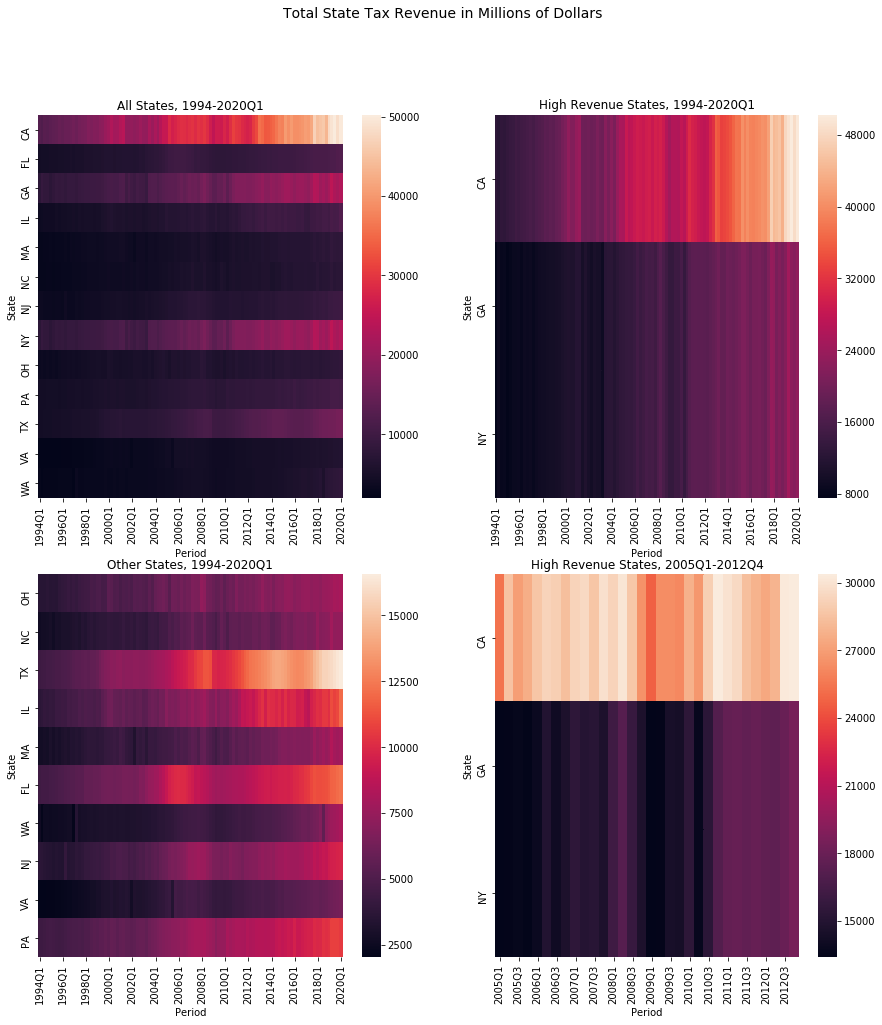

In [141]:
fig, axs = plt.subplots(2,2, figsize=(15,15))
ul = axs[0,0]
ur = axs[0,1]
ll = axs[1,0]
lr = axs[1,1]

sns.heatmap(top_15_total_val.transpose(),ax = ul,xticklabels = 8)
ul.set_ylabel("State")
ul.set_xlabel("Period")
ul.set_title("All States, 1994-2020Q1")
plt.subplots_adjust(bottom=.1)

# Isolate high revenue states
high_rev_states = ["CA","GA","NY"]
sns.heatmap(top_15_total_val[high_rev_states].transpose(),ax = ur,xticklabels = 8)
ur.set_ylabel("State")
ur.set_xlabel("Period")
ur.set_title("High Revenue States, 1994-2020Q1")

# Other states
other_states = list(set(top_15_total.columns) - set(high_rev_states))
sns.heatmap(top_15_total_val[other_states].transpose(),ax = ll,xticklabels = 8)
ll.set_ylabel("State")
ll.set_xlabel("Period")
ll.set_title("Other States, 1994-2020Q1")

# Zoom in on 2005-2012
sns.heatmap(top_15_total_val.loc[pd.Period('2005Q1'):pd.Period('2012Q4'),:][high_rev_states].transpose(),
            ax = lr,xticklabels = 2,robust = True)
lr.set_ylabel("State")
lr.set_xlabel("Period")
lr.set_title("High Revenue States, 2005Q1-2012Q4")
fig.suptitle("Total State Tax Revenue in Millions of Dollars",fontsize=14)
plt.show()

In [191]:
# Graph quarterly and yearly percent change
top_15_total_qchange = top_15_total.pivot("time", "state", "q_pct_change")
top_15_total_qchange.index = top_15_total_qchange.index.to_period(freq = "Q")
top_15_total_ychange = top_15_total.pivot("time", "state", "y_pct_change")
top_15_total_ychange.index = top_15_total_ychange.index.to_period(freq = "Q")

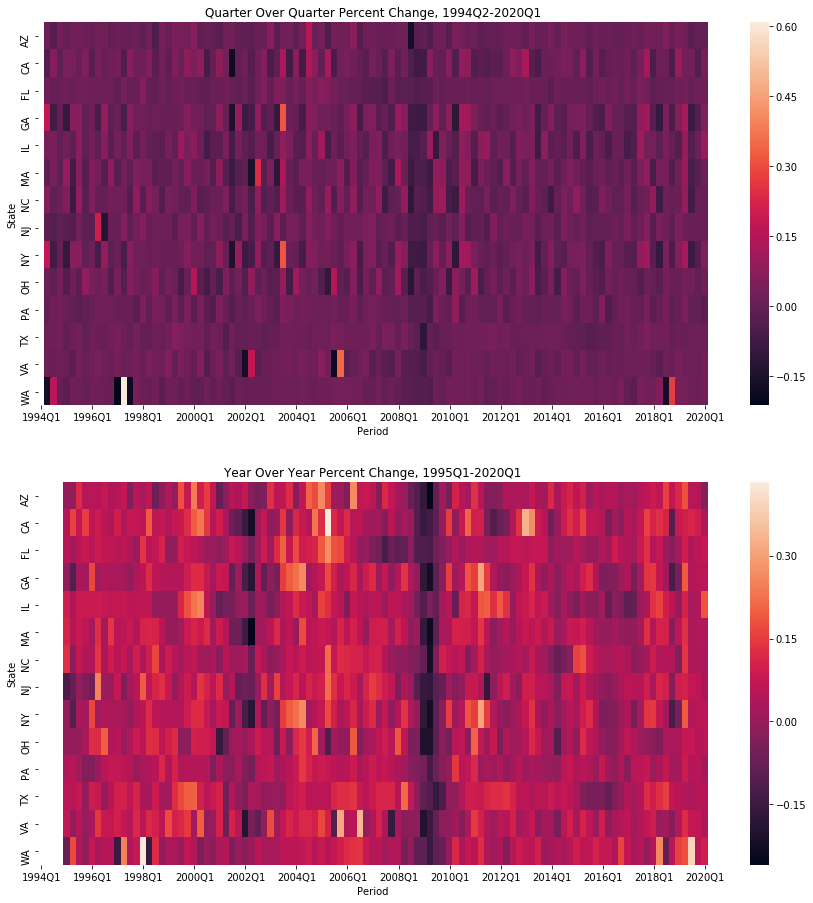

In [189]:
fig, (ax0,ax1) = plt.subplots(2,1,figsize=(15,15))
sns.heatmap(top_15_total_qchange.transpose(),ax = ax0,xticklabels = 8)
ax0.set_ylabel("State")
ax0.set_xlabel("Period")
ax0.set_title("Quarter Over Quarter Percent Change, 1994Q2-2020Q1")
plt.subplots_adjust(bottom=.1)
sns.heatmap(top_15_total_ychange.transpose(),ax = ax1,xticklabels = 8)
ax1.set_ylabel("State")
ax1.set_xlabel("Period")
ax1.set_title("Year Over Year Percent Change, 1995Q1-2020Q1")
plt.subplots_adjust(bottom=.1)

Notes:
* Outlier in Washington state during 1997, anomalous dip and spike. Attributable to volatile general
   sales and use taxes. Rate increases were approved in metro area for football stadium construction and new transi      system, also internet boom contributed to large sales tax increase.
* Outlier in California in 2005
* Florida revenue smoothest through recession (though decline begins earlier)
* States with severe dips in 2001-2002 also have severe dips in 2008-2009.

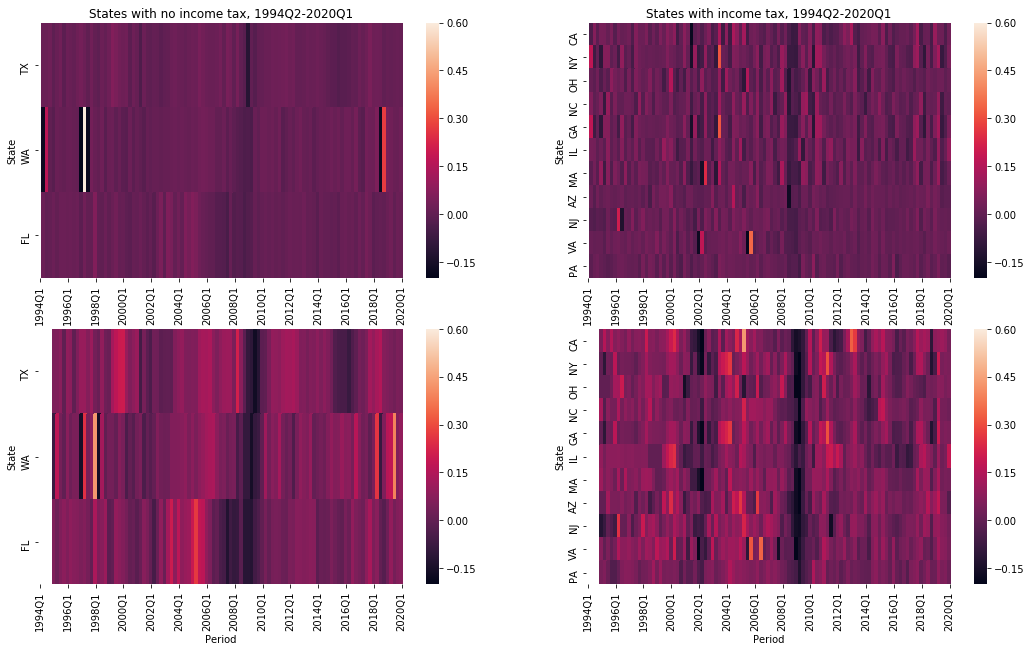

In [198]:
# Comparing states without income tax (FL, TX, WA) to states with income tax
no_income_tax = ['TX','WA','FL']
income_tax = list(set(top_15_total_qchange.columns) - set(no_income_tax))
min_ = -.2
max_ = .6
fig, axs = plt.subplots(2,2, figsize=(18,10))
ul = axs[0,0]
ur = axs[0,1]
ll = axs[1,0]
lr = axs[1,1]

sns.heatmap(top_15_total_qchange[no_income_tax].transpose(),ax = ul,xticklabels = 8, vmin = min_, vmax = max_)
ul.set_ylabel("State")
ul.set_xlabel("Period")
ul.set_title("States with no income tax, 1994Q2-2020Q1")
plt.subplots_adjust(bottom=.1)

sns.heatmap(top_15_total_qchange[income_tax].transpose(),ax = ur,xticklabels = 8,vmin = min_, vmax = max_)
ur.set_ylabel("State")
ur.set_xlabel("Period")
ur.set_title("States with income tax, 1994Q2-2020Q1")

sns.heatmap(top_15_total_ychange[no_income_tax].transpose(),ax = ll,xticklabels = 8,vmin = min_, vmax = max_)
ll.set_ylabel("State")
ll.set_xlabel("Period")

# Zoom in on 2005-2012
sns.heatmap(top_15_total_ychange[income_tax].transpose(),
            ax = lr,xticklabels = 8,vmin = min_, vmax = max_)
lr.set_ylabel("State")
lr.set_xlabel("Period")
plt.show()

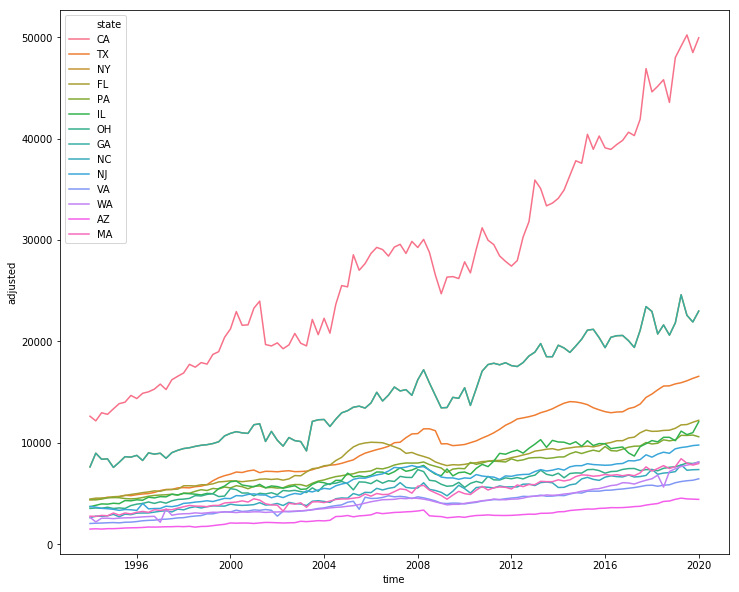

In [215]:
# Line plots
fig, ax = plt.subplots(figsize=(12,10))
sns.lineplot(x = "time", y = "adjusted", data = top_15_total, hue = "state")